# Launch download data for Lithuania using bash-API

The script uses SentinelHUb's batch API to download all acquisitions over a given time-interval.

The downloaded images are:

 * Sentinel-2 L1C B02, B03, B04, B08 (e.g. bands a t 10m resolution);
 * CLP band;
 * count of acquisitions;
 * data mask.

In [2]:
import json
import datetime
import pandas as pd
import geopandas as gpd

import requests

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

In [ ]:
# config

# Your client credentials
client_id = ''
client_secret = ''

batch_url = "https://services.sentinel-hub.com/api/v1/batch/process"

In [94]:
# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

## Main parameters of the batch request

In [4]:
YEAR = 2019
START_MONTH, START_DAY = 6, 1
END_MONTH, END_DAY = 8, 31

start_date = datetime.datetime(YEAR, START_MONTH, START_DAY)
end_date = datetime.datetime(YEAR, END_MONTH, END_DAY)

start_date, end_date, (end_date-start_date).days+1

(datetime.datetime(2019, 6, 1, 0, 0), datetime.datetime(2019, 8, 31, 0, 0), 92)

In [5]:
evalscript = """
//VERSION=3

var n_observations = {n_observations};
var start_date = new Date({year},{month},{day})

Date.prototype.getDOY = function(start) {{
  var diff = (this - start) + ((start.getTimezoneOffset() - this.getTimezoneOffset()) * 60 * 1000);
  var oneDay = 1000 * 60 * 60 * 24;
  var day = Math.floor(diff / oneDay);
  return day;
}}
function setup() {{
    return {{
        input: [{{
            bands: ["B02","B03","B04","B08","dataMask","CLP"], 
            units: "DN"
        }}],
        output: [        
           {{id: "B02", bands: n_observations, sampleType: SampleType.UINT16}},
           {{id: "B03", bands: n_observations, sampleType: SampleType.UINT16}},
           {{id: "B04", bands: n_observations, sampleType: SampleType.UINT16}},
           {{id: "B08", bands: n_observations, sampleType: SampleType.UINT16}},
           {{id: "dataMask", bands: n_observations, sampleType: SampleType.UINT8}},
           {{id: "CLP", bands: n_observations, sampleType: SampleType.UINT8}},
           {{id: "count", bands: 1, sampleType: SampleType.UINT16}}
        ],
        mosaicking: Mosaicking.ORBIT
    }}
}}
function evaluatePixel(samples, scenes) {{
    
    var _b02 = new Array(n_observations).fill(0);
    var _b03 = new Array(n_observations).fill(0);
    var _b04 = new Array(n_observations).fill(0);
    var _b08 = new Array(n_observations).fill(0);
    var _dataMask = new Array(n_observations).fill(0);
    var _CLP = new Array(n_observations).fill(0);
    
    for (var i = 0; i < samples.length; i++) {{
        var index = scenes[i].date.getDOY(start_date);
        _b02[index] = samples[i].B02;
        _b03[index] = samples[i].B03;
        _b04[index] = samples[i].B04;
        _b08[index] = samples[i].B08;
        _dataMask[index] = samples[i].dataMask
        _CLP[index] = samples[i].CLP
    }}
        
    return {{ B02: _b02, B03: _b03, B04: _b04, B08: _b08, 
             dataMask: _dataMask, CLP: _CLP , count: [samples.length] }};
}}
"""

Request geometry

In [3]:
with open('../../input-data/lithuania_geom_for_gridId_1.geojson','r') as gj:
    geom = json.load(gj)['features'][0]['geometry']
    geom['crs']={"type": "name", "properties": { "name": "urn:ogc:def:crs:OGC::CRS84" }}

In [91]:
# json.dumps(geom)

Don't forget to dump the value of geom into the payload>processRequest>input>bounds>geometry, update description, times, etc

In [7]:
payload = {
    "processRequest": {
        "input": {
            "bounds": {
                "bbox": None,
                "geometry": {
                    "crs": {
                        "type": "name",
                        "properties": {
                          "name": "urn:ogc:def:crs:OGC::CRS84"
                        }
                    },
                    "type": "Polygon", 
                    "coordinates": [ [ [ 25.472603378720596, 54.048527577868491 ], [ 25.469298743637758, 54.138373316633391 ], [ 25.465976008962997, 54.228217567385229 ], [ 25.312643839513665, 54.226167921838766 ], [ 25.316298330055094, 54.136330391722069 ], [ 25.163317820566213, 54.134093117569591 ], [ 25.16728221157998, 54.044261398061586 ], [ 25.014653054841183, 54.041837796265511 ], [ 25.018923754527748, 53.952012457087896 ], [ 24.866645620104563, 53.949403824493601 ], [ 24.871219066239416, 53.859585427572455 ], [ 24.719291600996392, 53.856793056870579 ], [ 24.567390651646313, 53.853808495785771 ], [ 24.415517975184983, 53.850631821577096 ], [ 24.263675326531359, 53.847263116448644 ], [ 24.111864458397747, 53.84370246754213 ], [ 24.04005660667605, 53.841927110215956 ], [ 24.039912878840003, 53.839949966929012 ], [ 24.0, 53.840936761828992 ], [ 23.960087121159997, 53.839949966929012 ], [ 23.95994339332395, 53.841927110215956 ], [ 23.888135541602253, 53.84370246754213 ], [ 23.736324673468641, 53.847263116448644 ], [ 23.584482024815017, 53.850631821577096 ], [ 23.432609348353687, 53.853808495785771 ], [ 23.437834059611667, 53.943607956553848 ], [ 23.443087252230395, 54.033405717190533 ], [ 23.290533462853233, 54.036409885051462 ], [ 23.295486258907186, 54.126215810947087 ], [ 23.300466162370064, 54.216020076798756 ], [ 23.147225093160888, 54.218849299291186 ], [ 22.993958527345189, 54.221483726245324 ], [ 22.998299756902771, 54.311304316337903 ], [ 22.844676245570565, 54.313751910643205 ], [ 22.691030703120024, 54.316003935162058 ], [ 22.694725447059145, 54.405838431843002 ], [ 22.540724297915585, 54.407901606344474 ], [ 22.544102142913534, 54.497741395305539 ], [ 22.547498633126207, 54.587579697760468 ], [ 22.550913908446336, 54.677416514091604 ], [ 22.70593240166593, 54.675332823542675 ], [ 22.709709473527198, 54.765161255164266 ], [ 22.713507515856691, 54.854988170896959 ], [ 22.55780138114952, 54.857085689921341 ], [ 22.561273865542578, 54.946918050193617 ], [ 22.405201684951955, 54.948822274748473 ], [ 22.408344764173105, 55.038659477104879 ], [ 22.251906259384956, 55.040369057046824 ], [ 22.249112077058726, 54.950526193023968 ], [ 22.093006974807846, 54.952029758900764 ], [ 21.936888312352046, 54.953332931675014 ], [ 21.780758024900837, 54.954435676062239 ], [ 21.782504868114653, 55.044291532076599 ], [ 21.626015611647372, 55.045196817052037 ], [ 21.627420985836295, 55.135054312887306 ], [ 21.47057262698231, 55.13576079199435 ], [ 21.313718364621714, 55.136265433698227 ], [ 21.156860166331885, 55.136568224228938 ], [ 21.15721351521287, 55.226429405983943 ], [ 21.0, 55.226530673342083 ], [ 20.84278648478713, 55.226429405983943 ], [ 20.842431152775518, 55.316289254217196 ], [ 20.842073822413621, 55.406147770507729 ], [ 20.84171447832286, 55.496004956447479 ], [ 21.0, 55.496107241736382 ], [ 21.0, 55.585963441327848 ], [ 21.0, 55.675818315355116 ], [ 21.0, 55.765671865461016 ], [ 20.8406242074639, 55.765568548273436 ], [ 20.840256651420106, 55.855420428985468 ], [ 20.839887002296987, 55.945270987498354 ], [ 21.0, 55.945375000544672 ], [ 21.0, 56.035224588872573 ], [ 21.0, 56.125072859979397 ], [ 21.160858640868433, 56.124968144613838 ], [ 21.161234668188943, 56.21481474659177 ], [ 21.161612855149848, 56.304660033121216 ], [ 21.323223533602661, 56.304343763393014 ], [ 21.323984243709333, 56.394186665402309 ], [ 21.485970880831434, 56.393657774684691 ], [ 21.647950936795354, 56.392917348989123 ], [ 21.809922218749858, 56.391965409622046 ], [ 21.811834658108655, 56.4817994646763 ], [ 21.974177269874669, 56.480632095442481 ], [ 22.136506619696164, 56.479252556963239 ], [ 22.298820500108491, 56.477660889077207 ], [ 22.461116704966742, 56.475857137740924 ], [ 22.62339302963429, 56.473841355024092 ], [ 22.785647271171307, 56.471613599104124 ], [ 22.947877228523321, 56.469173934260162 ], [ 23.110080702709734, 56.466522430866384 ], [ 23.272255497012353, 56.463659165384691 ], [ 23.434399417163945, 56.460584220356793 ], [ 23.596510271536754, 56.457297684395613 ], [ 23.758585871331036, 56.453799652176095 ], [ 23.920624030763602, 56.450090224425317 ], [ 23.920329344897784, 56.446240950599027 ], [ 24.079375969236398, 56.450090224425317 ], [ 24.08624513108094, 56.360363203337052 ], [ 24.247903393970358, 56.364060119155695 ], [ 24.409598802502181, 56.367546350256809 ], [ 24.571329188009656, 56.370821796644179 ], [ 24.565600582836055, 56.460584220356793 ], [ 24.727744502987647, 56.463659165384691 ], [ 24.889919297290266, 56.466522430866384 ], [ 25.052122771476679, 56.469173934260162 ], [ 25.056708476186291, 56.379382517747047 ], [ 25.218557026188243, 56.381813945629673 ], [ 25.222737230439904, 56.292012778629378 ], [ 25.384230458121902, 56.294225524939108 ], [ 25.388009510320803, 56.204415392062565 ], [ 25.549147055831096, 56.206410847954707 ], [ 25.71030401609487, 56.208196408755214 ], [ 25.871478238023421, 56.209772023519221 ], [ 25.874109482848688, 56.119942390817151 ], [ 26.034923139436238, 56.121303419556327 ], [ 26.037165861642425, 56.03146781725134 ], [ 26.039395833979231, 55.941630839135044 ], [ 26.199477196370097, 55.942774821181573 ], [ 26.359569102414049, 55.943710850523303 ], [ 26.361047535156171, 55.853865522547068 ], [ 26.36251759729916, 55.764018848342999 ], [ 26.521880929606571, 55.764742028138159 ], [ 26.681250491773916, 55.765258599604962 ], [ 26.68198143407777, 55.675406431633846 ], [ 26.682708254870903, 55.585552933434421 ], [ 26.683430985886989, 55.495698103413872 ], [ 26.684149658529275, 55.405841939991738 ], [ 26.842073822413621, 55.406147770507729 ], [ 27.0, 55.406249714950761 ], [ 27.0, 55.316390859354016 ], [ 27.0, 55.226530673342083 ], [ 26.84278648478713, 55.226429405983943 ], [ 26.843139833668115, 55.136568224228938 ], [ 26.843491214481226, 55.046705707385954 ], [ 26.68698438209697, 55.046403921114468 ], [ 26.530481455828848, 55.045900953111868 ], [ 26.373984388352628, 55.045196817052037 ], [ 26.375381951430441, 54.955337962200637 ], [ 26.219241975099163, 54.954435676062239 ], [ 26.220979129306382, 54.864578446348929 ], [ 26.065196112115331, 54.863479350585152 ], [ 25.90942463236474, 54.862180489330385 ], [ 25.911842781272956, 54.77232980958636 ], [ 25.756429920564397, 54.770836170044994 ], [ 25.759177968013528, 54.680989009489259 ], [ 25.91424757299573, 54.682477718700994 ], [ 25.916639107583418, 54.592624215714039 ], [ 25.919017484070746, 54.502769299672735 ], [ 25.764628731732564, 54.501290386289057 ], [ 25.767331673148966, 54.411438922079668 ], [ 25.770019802472749, 54.321586021764155 ], [ 25.923735153881665, 54.323055224654425 ], [ 25.926074640310684, 54.233196063810439 ], [ 25.928401354874818, 54.143335486178259 ], [ 25.775352062748496, 54.14187590975191 ], [ 25.77799640990953, 54.052018696539506 ], [ 25.62529180756367, 54.050370044529764 ], [ 25.472603378720596, 54.048527577868491 ] ] ]
                },
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                }
            },
            "data": [{
                "dataFilter": {
                    "timeRange": {
                        "from": start_date.isoformat()+'Z',
                        "to": end_date.isoformat()+'Z'
                    },
                "maxCloudCoverage": 70.0
                },
                "type": "S2L1C"
            }]
        },
        "output": {
            "responses": [{
                "identifier": "B02",
                "format": {
                    "type": "image/tiff"
                }},
                {
                "identifier": "B03",
                "format": {
                    "type": "image/tiff"
                }},
                {
                "identifier": "B04",
                "format": {
                    "type": "image/tiff"
                }},
                {
                "identifier": "B08",
                "format": {
                    "type": "image/tiff"
                }},
                {
                "identifier": "CLP",
                "format": {
                    "type": "image/tiff"
                }},
                {
                "identifier": "dataMask",
                "format": {
                    "type": "image/tiff"
                }},
                {
                "identifier": "count",
                "format": {
                    "type": "image/tiff"
                }}]
        },
        "evalscript": evalscript.format(n_observations=(end_date-start_date).days+1, 
                                        year=YEAR, month=START_MONTH-1, day=START_DAY)
    },
    "tilingGridId": 1,
    "bucketName": "bucket-name",
    "resolution": 10.0,
    "description": "Lithuania entire - June/August - 92 days"
}

headers = {
  'Content-Type': 'application/json'
}

Submit the request (nothing happens yet)

In [ ]:
response = oauth.request("POST", batch_url, headers=headers, json = payload)
response

Get response for batch process

In [51]:
response = oauth.request("GET", f"{batch_url}/{batch_request_id}")
response.json()['id']

'ab0442c1-6c27-4bec-a798-8953ad955698'

Run analysis (get n tiles, estimated costs, ...)

In [13]:
response = oauth.request("POST", f"{batch_url}/{batch_request_id}/analyse")
response

<Response [204]>

Wait some time and check `oauth.request("GET", f"{batch_url}/{batch_request_id}")` to see if analysis is done

In [95]:
response = oauth.request("GET", f"{batch_url}/{batch_request_id}")
response.json()['status']

'PARTIAL'

Start batch process

In [15]:
#response = oauth.request("POST", f"{batch_url}/{batch_request_id}/start")
#response.status_code

204

Check status of batch request

In [35]:
batch_request_id

'ab0442c1-6c27-4bec-a798-8953ad955698'

In [36]:
response = oauth.request("GET", f"{batch_url}/{batch_request_id}")
response.json()['status']

'PROCESSING'

Get dataframe of all tiles

In [44]:
def get_tiles(batch_id):
    viewtoken = 0
    response_count = 100

    tiles = []
    while response_count == 100:
        url = f"{batch_url}/{batch_id}/tiles?viewtoken={viewtoken}"
        response = oauth.request("GET", url).json()
        response_count = len(response['member'])
        viewtoken = viewtoken + response_count
        tiles = tiles + response['member']

    gdf = gpd.GeoDataFrame(tiles)
    gdf['gg'] = gdf.geometry.apply(lambda gj: shape(gj))
    gdf = gdf.rename(columns={'geometry':'geojson','gg':'geometry'}).set_geometry('geometry')
    return gdf

In [45]:
first_3m = get_tiles('964d90b7-41a7-4025-a392-140ae5236bf5')

In [47]:
first_3m.query('status=="FAILED"')

,id,requestId,geojson,status,cost,geometry
479,1703269,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",FAILED,0.0,"POLYGON ((24.19725 54.83472, 24.19101 54.92448..."


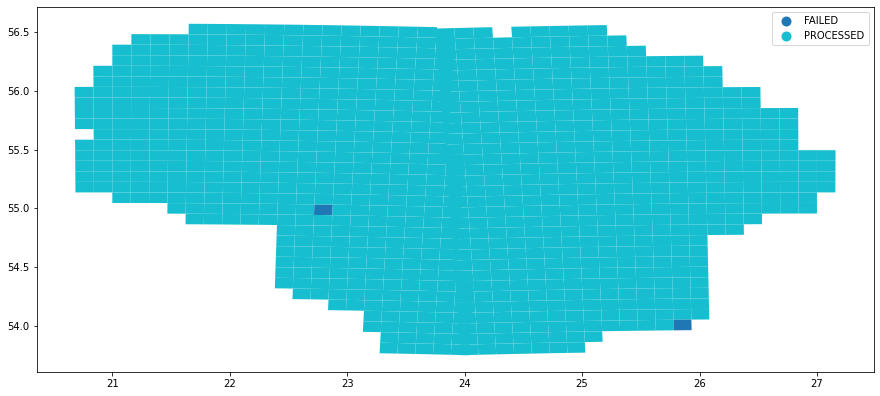

In [96]:
get_tiles(batch_request_id).plot('status',figsize=(15,15), legend=True)

## Read tiff from s3 directly

In [49]:
aws_access_key_id=""
aws_secret_access_key=""
region="eu-central-1"

In [100]:
import rasterio
from sentinelhub import BBox, CRS
import boto3

In [102]:
batch_request_id ='ab0442c1-6c27-4bec-a798-8953ad955698'

In [104]:
session = boto3.Session(aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key) 

with rasterio.Env(rasterio.session.AWSSession(session)) as env:
    with rasterio.open(f's3://bucket-niva/{batch_request_id}/1703758/B02.tif') as source:
        data_bbox = BBox(source.bounds, CRS(source.crs.to_epsg()))

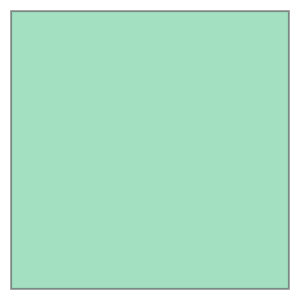

In [65]:
data_bbox

In [105]:
source.count

92